In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchmetrics import Metric
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy
import logging
import os
logging.getLogger("lightning").addHandler(logging.NullHandler())
logging.getLogger("lightning").propagate = False
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

2022-12-11 11:52:34.270572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 11:52:49.992335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-11 11:53:17.913776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-11 11:53:17.914392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [64]:
class History:
    def __init__(self):
        self.history = {}

def get_activation_function(name):
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "linear":
        return None

def mee(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).sqrt().mean()

def mse(y_true, y_pred):
    return (y_true - y_pred).square().sum(axis=1).mean()
    
class MEE(Metric):
    
    def __init__(self):
        super().__init__()
        self.add_state("result", default=torch.tensor(0.0))
        
    def update(self, y_pred, y_true):
        self.result += mee(y_true, y_pred)

    def compute(self):
        return self.result
    

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, input_dim, output_dim, config):
        super(MultiLayerPerceptron, self).__init__()
        
        task = config["task"]
        self.lr = config["learning_rate"]
        self.momentum = config["momentum"]
        self.nesterov = config["nesterov"]
        init = config["initialization"]
        reg_method = config["regularization"]["method"]
        
        if reg_method != None:
            value = config["regularization"]["value"]
            if reg_method == "l1":
                pass
            elif reg_method == "l2":
                pass
        
        self.task = task
        self.model = nn.Sequential()
        
        units = config["units_1"]
        
        self.model.add_module("linear_input", nn.Linear(input_dim, units))
        
        n_layers = 0
        for key in config.keys():
            if key.startswith("units_"):
                n_layers += 1
                
        for n_layer in range(1, n_layers+1):
            out_units = config[f"units_{n_layer}"]
            self.model.add_module(f"linear_{n_layer}", nn.Linear(units, out_units))
            activation = get_activation_function(config[f"activations_{n_layer}"])
            if activation != None:
                self.model.add_module(f"activations_{n_layer}", activation)
            units = out_units
        
        if task == "classification":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.model.add_module("activations_output", nn.Sigmoid())
            self.metric = Accuracy()
            self.metric_name = "accuracy"
        
        if task == "regression":
            self.model.add_module("layer_output", nn.Linear(units, output_dim))
            self.metric = MEE()
            self.metric_name = "mee"
                    
        if init["type"] == "uniform":
            self.min = init["min"]
            self.max = init["max"]
            self.apply(self.init_weights_uniform)
        elif init["type"] == "normal":
            self.mean = init["mean"]
            self.std = init["std"]
            self.apply(self.init_weights_normal)
            
            
        self.loss = nn.MSELoss()
        self.dicts = []
            
            

    def init_weights_uniform(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight, self.min, self.max)
            torch.nn.init.uniform_(m.bias, self.min, self.max)
            # m.bias.data.fill_(0.01)
            
            

    def init_weights_normal(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, sefl.mean, sefl.std)
            torch.nn.init.normal_(m.bias, sefl.mean, sefl.std)
            # m.bias.data.fill_(0.01)

            
            
    def compute_metric(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.metric(y_pred, y_true.to(torch.int32))
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.metric(y_pred, y_true)
        


    def compute_loss(self, y_pred, y_true):
        if self.task == "classification":
            y_pred = y_pred.reshape(y_true.shape)  
            return self.loss(y_pred, y_true)
        elif self.task == "regression":
            y_true = y_true.to(torch.float32)
            return self.loss(y_pred, y_true)
    
    
    def forward(self, x):
        return self.model(x)

    
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, nesterov=self.nesterov)
        return optimizer
    
    
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X)
        # accuracy
        acc = self.compute_metric(y_pred, y_copy)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'loss': loss, f'{self.metric_name}': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'val_loss': loss, f'val_{self.metric_name}': acc}, prog_bar=True, logger=True)
        return loss
    
    
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X)
        # compute metrics 
        acc = self.compute_metric(y_pred, y)
        # compute loss
        loss = self.compute_loss(y_pred, y)
        self.log_dict({'test_loss': loss, f'test_{self.metric_name}': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

    
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [75]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged

def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:        
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"],
            min_delta=early_stopping["delta"],
            patience=early_stopping["patience"], 
            verbose=False,
            mode="min"
        )
        
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    model = MultiLayerPerceptron(input_size, output_size, config)
    return model
    
    
    
def fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, metric, config):  
    
    train_loader = DataLoader(dataset = CustomDataset(x_train, y_train), batch_size=batch_size)
    validation_loader = DataLoader(dataset = CustomDataset(x_val, y_val), batch_size=batch_size)
    
    callbacks = get_callbacks(config)
        
    trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,
                         log_every_n_steps=5, logger=CSVLogger(save_dir="logs/"),
                         callbacks=callbacks, enable_progress_bar=False,
                         enable_model_summary=False
                        )  
    
    
    trainer.fit(model=model, train_dataloaders=train_loader,
                val_dataloaders=validation_loader) 
    
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    

    history = History()
            
    history.history["loss"] = metrics["loss"].dropna().to_list()
    history.history["val_loss"] = metrics["val_loss"].dropna().to_list()
    history.history[f"{metric}"] = metrics[f"{metric}"].dropna().to_list()
    history.history[f"val_{metric}"] = metrics[f"val_{metric}"].dropna().to_list()
    
    
    return history
    
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                
                model = get_model(config, input_size, output_size)
                history = fit(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, 
                              max_epochs, batch_size, train_metric, config)
                
                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)  

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
                        
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = fit(model, x_train, y_train, x_val, y_val, max_epochs, batch_size, train_metric, config)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    
    y_pred = model(torch.from_numpy(x_test).to(torch.float32))
    y_test = torch.from_numpy(y_test).to(torch.float32)
    
    acc = model.compute_metric(y_pred, y_test)
    loss = model.compute_loss(y_pred, y_test)
    
    print(f"Test MSE: {loss}")
    print(f"Test accuracy: {acc}")
    
    #test_loader = DataLoader(dataset = CustomDataset(x_test, y_test), batch_size=batch_size)
    #trainer.test(model=model, dataloaders=test_loader)
    #input_size = x_test.shape[1]
    #result = model.evaluate(x_test, y_test)
    #print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model(torch.from_numpy(x_train).to(torch.float32))
    y_test_pred = model(torch.from_numpy(x_test).to(torch.float32))
    
    if scale:
        
        y_train_pred = y_train_pred.detach().numpy()
        y_test_pred = y_test_pred.detach().numpy()
        
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)
        
        y_train_pred  = torch.from_numpy(y_train_pred).to(torch.float32)
        y_test_pred  = torch.from_numpy(y_test_pred).to(torch.float32)
        
    y_train = torch.from_numpy(y_train).to(torch.float32)
    y_test = torch.from_numpy(y_test).to(torch.float32)
    

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:
        
        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# Monk 1

In [31]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [32]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


Testing configuration 1/1:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [00:56<00:00, 11.38s/it]


Median val_loss: 0.0003959190006905, std val_loss 0.07434769778245914
Median train_loss: 4.093664756510407e-05, std train_loss 0.031120574655818637
Median val_accuracy: 1.0, std val_accuracy 0.12275687780029733
Median train_accuracy: 1.0, train_accuracy 0.031872761015819144






Best configuration (loss 0.0003959190006905):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:00<00:08,  1.05it/s]

Trial 1/10 val_mse: 0.1880908653479487
Trial 1/10 train_mse: 0.068849042057991
Trial 1/10 val_accuracy: 0.800000011920929
Trial 1/10 train_accuracy: 0.9292929172515868


 20%|████████▊                                   | 2/10 [00:15<01:10,  8.86s/it]

Trial 2/10 val_mse: 0.0358290707064865
Trial 2/10 train_mse: 5.031006730860099e-05
Trial 2/10 val_accuracy: 0.9200000166893004
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:16<00:37,  5.38s/it]

Trial 3/10 val_mse: 0.1976093355373601
Trial 3/10 train_mse: 0.0648401528596878
Trial 3/10 val_accuracy: 0.800000011920929
Trial 3/10 train_accuracy: 0.9292929172515868


 40%|█████████████████▌                          | 4/10 [00:33<00:59,  9.87s/it]

Trial 4/10 val_mse: 0.0038947818254406
Trial 4/10 train_mse: 6.250447768252343e-05
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:51<01:04, 12.81s/it]

Trial 5/10 val_mse: 0.1200813972692264
Trial 5/10 train_mse: 0.0202369932085275
Trial 5/10 val_accuracy: 0.8799999952316284
Trial 5/10 train_accuracy: 0.9797979593276978


 60%|██████████████████████████▍                 | 6/10 [01:06<00:54, 13.56s/it]

Trial 6/10 val_mse: 0.0053267121700404
Trial 6/10 train_mse: 6.273275357671082e-05
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:08<00:29,  9.78s/it]

Trial 7/10 val_mse: 0.1655739057544377
Trial 7/10 train_mse: 0.0669656917452812
Trial 7/10 val_accuracy: 0.800000011920929
Trial 7/10 train_accuracy: 0.939393937587738


 80%|███████████████████████████████████▏        | 8/10 [01:10<00:14,  7.36s/it]

Trial 8/10 val_mse: 0.1239491893685892
Trial 8/10 train_mse: 0.0012043830938637
Trial 8/10 val_accuracy: 0.8399999737739563
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [01:24<00:09,  9.40s/it]

Trial 9/10 val_mse: 0.0008563815817562
Trial 9/10 train_mse: 5.55277474632021e-05
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:38<00:00,  9.89s/it]

Trial 10/10 val_mse: 0.1201346999520289
Trial 10/10 train_mse: 0.0202403478324413
Trial 10/10 val_accuracy: 0.8799999952316284
Trial 10/10 train_accuracy: 0.9797979593276978

Median val_mse: 0.1201346999520289, std val_mse: 0.07413970020779016
Median train_mse: 0.0202403478324413, std train_mse: 0.028923352562091807
Median val_accuracy: 0.8799999952316284, std val_accuracy: 0.08009993589925016
Median train_accuracy: 0.9797979593276978, std train_accuracy: 0.02934513285987745


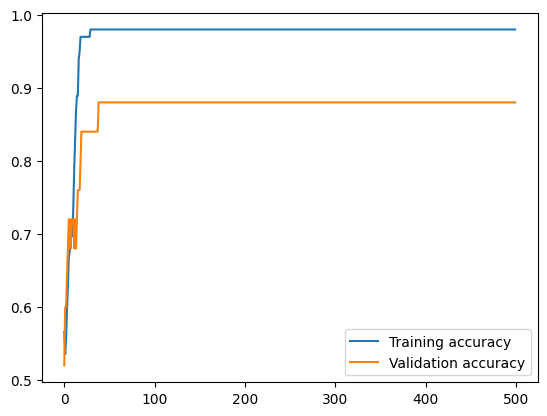

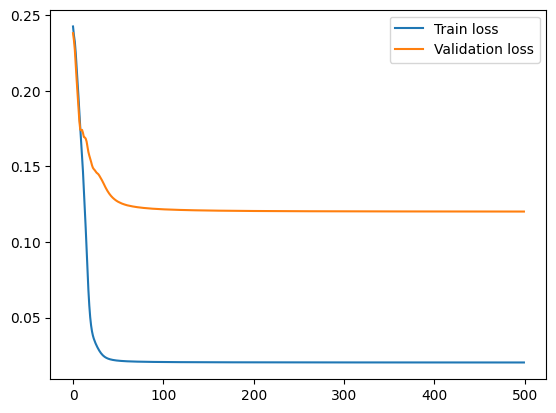

Test MSE: 0.08367505669593811
Test accuracy: 0.9166666865348816


In [15]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# Monk 2

In [68]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [70]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


Testing configuration 1/1:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]


Fold 1/5 median val_loss: 0.2256033870260097, std val_loss 0.12159193222842173
Fold 1/5 median train_loss: 0.1341433227062225, std train_loss 0.06403663385795019
Fold 1/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.2189942367242775
Fold 1/5 median train_accuracy: 0.8444444537162781, train_accuracy 0.08744506297369344

Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


Fold 2/5 median val_loss: 0.3243439174101592, std val_loss 0.13453818606950435
Fold 2/5 median train_loss: 0.1571930646896362, std train_loss 0.06492842906528626
Fold 2/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.19385007974544197
Fold 2/5 median train_accuracy: 0.8370370268821716, train_accuracy 0.07867210225804727

Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:09<00:00,  1.96s/it]


Fold 3/5 median val_loss: 0.0014796349793606, std val_loss 0.08186608337936921
Fold 3/5 median train_loss: 0.0014864812837913, std train_loss 0.08443192725993856
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.11764705181121826
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.12444443702697754

Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:07<00:00,  1.51s/it]


Fold 4/5 median val_loss: 0.0007156482373301, std val_loss 0.13181416690970713
Fold 4/5 median train_loss: 0.0007585189887322, std train_loss 0.09464552097461768
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.22352940534290536
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.1370350456684979

Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


Fold 5/5 median val_loss: 0.0008892334949802, std val_loss 0.10022355222721502
Fold 5/5 median train_loss: 0.0005085755256004, std train_loss 0.08216409496266151
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.15757575035095214
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.12647058963775634

Mean val_loss: 0.11060636422956796, std val_loss: 0.1377900708806239
Mean train_loss: 0.05881799263879652, std train_loss: 0.07128724002179754
Mean val_accuracy: 0.8176470637321472, std val_accuracy: 0.22352940534290536
Mean train_accuracy: 0.8176470637321472, std train_accuracy: 0.07805594038467291






Best configuration (loss 0.11060636422956796):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regulariza

 10%|████▍                                       | 1/10 [00:03<00:33,  3.75s/it]

Trial 1/10 val_mse: 0.0899460925146412
Trial 1/10 train_mse: 0.0161810610443353
Trial 1/10 val_accuracy: 0.911764681339264
Trial 1/10 train_accuracy: 0.985185205936432


 20%|████████▊                                   | 2/10 [00:05<00:20,  2.55s/it]

Trial 2/10 val_mse: 0.0006877333386454
Trial 2/10 train_mse: 0.0004679653793573
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:08<00:19,  2.78s/it]

Trial 3/10 val_mse: 0.0007048932412396
Trial 3/10 train_mse: 0.0005546222673729
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:09<00:11,  1.92s/it]

Trial 4/10 val_mse: 0.2483258171634412
Trial 4/10 train_mse: 0.225991204380989
Trial 4/10 val_accuracy: 0.5882353186607361
Trial 4/10 train_accuracy: 0.6740740537643433


 50%|██████████████████████                      | 5/10 [00:10<00:09,  1.90s/it]

Trial 5/10 val_mse: 0.0008432529099449
Trial 5/10 train_mse: 0.0004766671627294
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:13<00:08,  2.00s/it]

Trial 6/10 val_mse: 0.0005260885060354
Trial 6/10 train_mse: 0.000418661365984
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:15<00:06,  2.20s/it]

Trial 7/10 val_mse: 0.0005562441384831
Trial 7/10 train_mse: 0.0003836216055788
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [00:18<00:04,  2.23s/it]

Trial 8/10 val_mse: 0.000795574627196
Trial 8/10 train_mse: 0.0004398142918944
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [00:21<00:02,  2.56s/it]

Trial 9/10 val_mse: 0.0018260349681623
Trial 9/10 train_mse: 0.0011001852108165
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]

Trial 10/10 val_mse: 0.0005254088030118
Trial 10/10 train_mse: 0.0003523163031786
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 0.000795574627196, std val_mse: 0.07607769183231593
Median train_mse: 0.0004398142918944, std train_mse: 0.06728062793789728
Median val_accuracy: 1.0, std val_accuracy: 0.12342431861573601
Median train_accuracy: 1.0, std train_accuracy: 0.09738417496841453


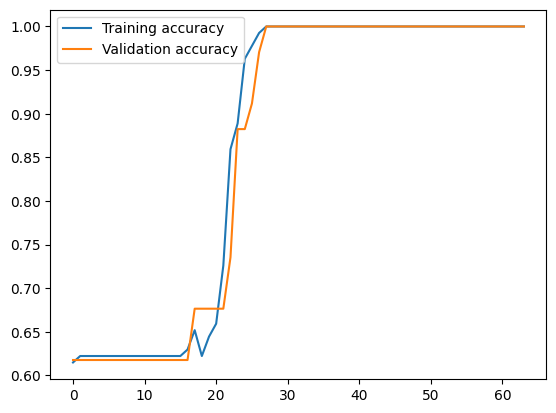

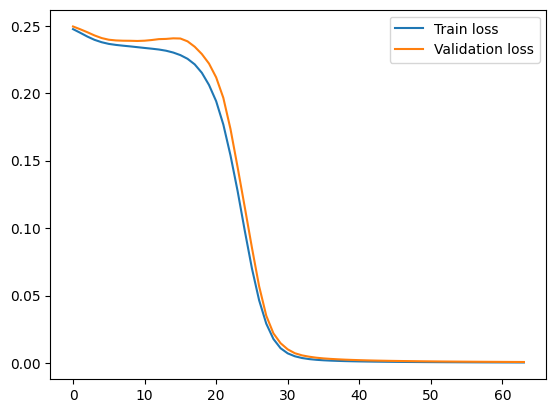

Test MSE: 0.0007630878244526684
Test accuracy: 1.0


In [71]:
model = grid_search(params, x_train, y_train, hold_out)
test_model(model, x_test, y_test)

# Monk 3

In [47]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


In [48]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.2
}


Testing configuration 1/1:
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 1e-05}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.24it/s]


Median val_loss: 0.1281602367657238, std val_loss 0.011477284218479513
Median train_loss: 0.0298494342714548, std train_loss 0.0027882831119229626
Median val_accuracy: 0.8799999952316284, std val_accuracy 0.019595928454334978
Median train_accuracy: 0.969072163105011, train_accuracy 0.005050494616049728






Best configuration (loss 0.1281602367657238):
{'batch_size': 32, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 1e-05}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:01<00:09,  1.09s/it]

Trial 1/10 val_mse: 0.0521668267761602
Trial 1/10 train_mse: 0.0353657007217407
Trial 1/10 val_accuracy: 0.9200000166893004
Trial 1/10 train_accuracy: 0.969072163105011


 20%|████████▊                                   | 2/10 [00:01<00:06,  1.15it/s]

Trial 2/10 val_mse: 0.0451271656577098
Trial 2/10 train_mse: 0.0376061424612998
Trial 2/10 val_accuracy: 0.959999978542328
Trial 2/10 train_accuracy: 0.969072163105011


 30%|█████████████▏                              | 3/10 [00:03<00:09,  1.29s/it]

Trial 3/10 val_mse: 0.0279095155872591
Trial 3/10 train_mse: 0.0471542403101921
Trial 3/10 val_accuracy: 0.959999978542328
Trial 3/10 train_accuracy: 0.9484536051750184


 40%|█████████████████▌                          | 4/10 [00:04<00:06,  1.10s/it]

Trial 4/10 val_mse: 0.0491748436235008
Trial 4/10 train_mse: 0.0383316278457641
Trial 4/10 val_accuracy: 0.959999978542328
Trial 4/10 train_accuracy: 0.969072163105011


 50%|██████████████████████                      | 5/10 [00:05<00:04,  1.06it/s]

Trial 5/10 val_mse: 0.0505536493350204
Trial 5/10 train_mse: 0.040786400437355
Trial 5/10 val_accuracy: 0.959999978542328
Trial 5/10 train_accuracy: 0.969072163105011


 60%|██████████████████████████▍                 | 6/10 [00:05<00:03,  1.14it/s]

Trial 6/10 val_mse: 0.0419874368741137
Trial 6/10 train_mse: 0.0345740839838981
Trial 6/10 val_accuracy: 0.9200000166893004
Trial 6/10 train_accuracy: 0.969072163105011


 70%|██████████████████████████████▊             | 7/10 [00:06<00:02,  1.14it/s]

Trial 7/10 val_mse: 0.062353756753257
Trial 7/10 train_mse: 0.0386992916464805
Trial 7/10 val_accuracy: 0.9200000166893004
Trial 7/10 train_accuracy: 0.969072163105011


 80%|███████████████████████████████████▏        | 8/10 [00:07<00:01,  1.01it/s]

Trial 8/10 val_mse: 0.047324082559292
Trial 8/10 train_mse: 0.038536436855793
Trial 8/10 val_accuracy: 0.959999978542328
Trial 8/10 train_accuracy: 0.969072163105011


 90%|███████████████████████████████████████▌    | 9/10 [00:08<00:00,  1.07it/s]

Trial 9/10 val_mse: 0.0446966210246023
Trial 9/10 train_mse: 0.0385687611997127
Trial 9/10 val_accuracy: 0.959999978542328
Trial 9/10 train_accuracy: 0.9587628841400146


100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.04it/s]

Trial 10/10 val_mse: 0.0587643083857839
Trial 10/10 train_mse: 0.0407725125551223
Trial 10/10 val_accuracy: 0.9200000166893004
Trial 10/10 train_accuracy: 0.969072163105011

Median val_mse: 0.0491748436235008, std val_mse: 0.008980896338813712
Median train_mse: 0.0383316278457641, std train_mse: 0.0032937327058434342
Median val_accuracy: 0.959999978542328, std val_accuracy: 0.019595899254141885
Median train_accuracy: 0.969072163105011, std train_accuracy: 0.006601159401122439


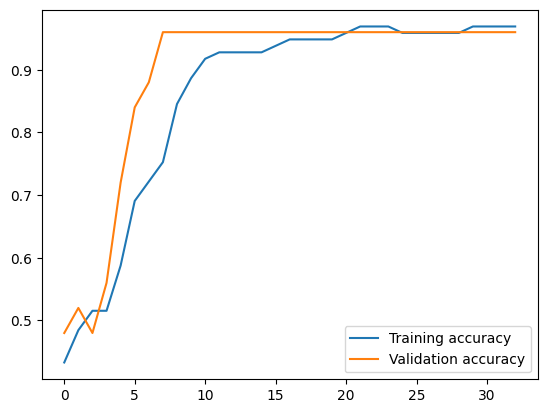

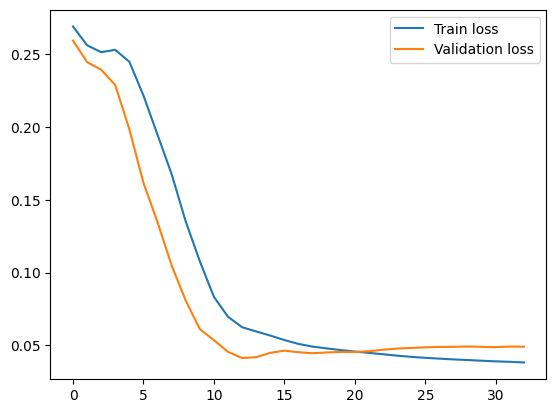

Test MSE: 0.04439050331711769
Test accuracy: 0.9490740895271301


In [49]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# ML Cup

In [61]:
x_train, y_train, x_test, y_test = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
#print(x_test_blind.shape)

(1343, 9) (1343, 2)
(149, 9) (149, 2)


In [76]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [32],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [77]:
model = grid_search(params, x_train, y_train, hold_out_val)
assess_model(model, x_train, y_train, x_test, y_test, True)

Train MSE: 4.9288530349731445
Train MEE: 1.8185940980911255
Test MSE: 5.8448591232299805
Test MEE: 1.9191449880599976
